# <center> Relax Challenge Take-Home Assignment </center> #

### Import packages ###

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

### Import data ###

In [2]:
cust_df = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
cust_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
login_df = pd.read_csv('takehome_user_engagement.csv')
login_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
#Fix data type
login_df.time_stamp = pd.to_datetime(login_df.time_stamp)

### Data Pre-Processing ###
In this step, we will calculate the number of logins for a given user within a 7 days prior to a given login. Ultimately, this will become our classification target for data modeling.

In [5]:
#Calculate 7-day rolling window calculation for number of logins for a given user ID
login_df = login_df.set_index('time_stamp')
new_df = login_df.groupby('user_id').rolling('7D').visited.count()
df = pd.DataFrame(new_df)
df = df.reset_index()

In [6]:
#Add maximum user affinity measure to customer data
cust_df['7d_freq'] = df.groupby('user_id').max().visited

This histogram provides a quick glimpse on the distribution of our target variable. With more time, we could further explore our features as well, but what's most critical is to get a sense of the distribution of our target customers.

<AxesSubplot:ylabel='Frequency'>

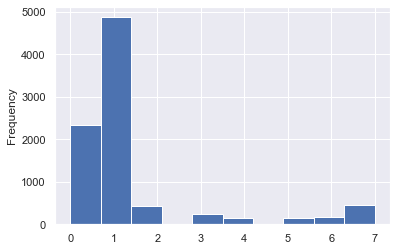

In [25]:
cust_df['7d_freq'].plot(kind='hist')

In [7]:
#Create target for logistic regression
cust_df['target'] = np.where(cust_df['7d_freq'] > 2,1,0)
cust_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,7d_freq,target
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0,0


### Data Cleaning ###

In [8]:
cust_df.creation_source = cust_df.creation_source.astype('category')

#Reduce cardinality of invitation offers
cust_df.org_id = np.where(cust_df.org_id > 0, 1,0)
cust_df.invited_by_user_id = np.where(cust_df.invited_by_user_id > 0, 1,0)

#Drop descriptive variables that cannot participate in modeling
cust_df = cust_df.drop(['creation_time','email','name'],axis=1)
cust_df.dtypes

object_id                        int64
creation_source               category
last_session_creation_time     float64
opted_in_to_mailing_list         int64
enabled_for_marketing_drip       int64
org_id                           int32
invited_by_user_id               int32
7d_freq                        float64
target                           int32
dtype: object

In [9]:
cust_df = pd.get_dummies(cust_df)

### Data Preprocessing ###
We can take a quick look at the correlation coefficients of our features, both to identify possible collinearity and to get a first look at the relationships to our target. There don't appear to be any strong one-on-one correlations, nor are there are variables disproportionately connecting to our target (note that 7-day frequency will not be included as a feature)

In [10]:
cust_df.corr()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,7d_freq,target,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
object_id,1.000000,0.015238,-0.032370,-0.022040,-0.013565,-0.009149,-0.000223,0.005863,-0.006909,-0.003988,-0.003357,0.002692,0.015089
last_session_creation_time,0.015238,1.000000,0.006590,0.008035,0.048954,0.004916,0.003245,0.001123,0.015054,-0.006940,0.001361,-0.006164,-0.000824
opted_in_to_mailing_list,-0.032370,0.006590,1.000000,0.483529,0.003101,0.006934,-0.009024,-0.003227,0.000667,0.006694,-0.007432,0.002181,-0.004555
enabled_for_marketing_drip,-0.022040,0.008035,0.483529,1.000000,0.008194,0.002216,0.022893,0.012902,-0.002438,0.004270,-0.007518,0.004528,0.000127
org_id,-0.013565,0.048954,0.003101,0.008194,1.000000,0.012032,0.015517,0.008509,0.003369,0.009839,-0.016167,0.006122,-0.006780
invited_by_user_id,-0.009149,0.004916,0.006934,0.002216,0.012032,1.000000,-0.000502,0.002127,0.437386,0.691238,-0.495336,-0.491916,-0.387255
7d_freq,-0.000223,0.003245,-0.009024,0.022893,0.015517,-0.000502,1.000000,0.920458,0.012884,-0.010899,-0.015036,0.004420,0.013436
target,0.005863,0.001123,-0.003227,0.012902,0.008509,0.002127,0.920458,1.000000,0.012901,-0.008149,-0.015971,0.004128,0.010814
creation_source_GUEST_INVITE,-0.006909,0.015054,0.000667,-0.002438,0.003369,0.437386,0.012884,0.012901,1.000000,-0.347502,-0.216653,-0.215157,-0.169380
creation_source_ORG_INVITE,-0.003988,-0.006940,0.006694,0.004270,0.009839,0.691238,-0.010899,-0.008149,-0.347502,1.000000,-0.342395,-0.340031,-0.267686


In [12]:
cust_df['7d_freq'] = cust_df['7d_freq'].fillna(0)
cust_df = cust_df.dropna()

### Data Modeling ###
We'll split into test- and training sets, a create a logistic regression model with scikit-learn. The model is accurate, and the table below illustrates the weight of each feature. The most significant features are whether or not a user was invited by an organization, users who utilized GUEST_SIGNUP, and whether or not the user was enabled for marketing drip.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X = cust_df.drop(['7d_freq','target'],axis=1)
y = cust_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X_train)

In [15]:
clf = LogisticRegression(random_state=42).fit(scaled_X,y_train)
X_test_scaled = scaler.transform(X_test)
clf.score(X_test_scaled,y_test)

0.8696883852691218

In [16]:
features = list(cust_df.columns)
features.remove('7d_freq')
features.remove('target')
coefs_df = pd.DataFrame(clf.coef_, columns = features).transpose().rename(columns={0:'Features'})
coefs_df

,Features
object_id,0.004382
last_session_creation_time,-0.014812
opted_in_to_mailing_list,0.014170
enabled_for_marketing_drip,0.059311
org_id,0.071920
invited_by_user_id,-0.002685
creation_source_GUEST_INVITE,0.061644
creation_source_ORG_INVITE,-0.052321
creation_source_PERSONAL_PROJECTS,-0.070007
creation_source_SIGNUP,0.023696


### Exploration of Linear Regression ###
The originial goal was to define our target variable for a classification algorithm, but it's worth checking whether or not a linear model might better predict the number of logins for a user in a given 7-day period. This model is also accurate and focuses on the same issues. It might be worth exploring whether to limit the business definition of loyalty to >3 logins per week, and instead treat it as a continuous feature that can be expanded over time.

In [21]:
import statsmodels.api as sm
x = sm.add_constant(X)
y2 = cust_df['7d_freq']
results = sm.OLS(y2,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                7d_freq   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.090
Date:                Fri, 18 Sep 2020   Prob (F-statistic):             0.0270
Time:                        15:16:36   Log-Likelihood:                -17405.
No. Observations:                8823   AIC:                         3.483e+04
Df Residuals:                    8813   BIC:                         3.490e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  0.5804      1.029      0.564      0.573      -1.438       2.598
object_id                          -1.585e-06   5.36e-06     -0.296      0.767   -1.21e-05    8.91e-06
last_session_creation_time          2.937e-10    9.5e-10      0.309      0.757   -1.57e-09    2.16e-09
opted_in_to_mailing_list              -0.0276      0.049     -0.564      0.573      -0.123       0.068
enabled_for_marketing_drip             0.1130      0.059      1.910      0.056      -0.003       0.229
org_id                                 0.2076      0.117      1.775      0.076      -0.022       0.437
invited_by_user_id                     0.1231      0.188      0.654      0.513      -0.246       0.492
creation_source_GUEST_INVITE           0.1202      0.099      1.215      0.224      -0.074       0.314
creation_source_ORG_INVITE             0.0029      0.097      0.030      0.976      -0.187       0.193
creation_source_PERSONAL_PROJECTS      0.0358      0.285      0.126      0.900      -0.524       0.595
creation_source_SIGNUP                 0.1930      0.283      0.682      0.495      -0.361       0.747
creation_source_SIGNUP_GOOGLE_AUTH     0.2285      0.284      0.806      0.420      -0.327       0.784
==============================================================================
Omnibus:                     3705.119   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13106.791
Skew:                           2.189   Prob(JB):                         0.00
Kurtosis:                       7.061   Cond. No.                     1.12e+25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.35e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""